# Table of Contents

<ol class="toc-item"><li><a href="#Prepare-&amp;-Configure-Data">Prepare &amp; Configure Data</a><ol class="toc-item"><li><a href="#Collect-latest-data-from-GitHub">Collect latest data from GitHub</a></li><li><a href="#Clean-data">Clean data</a><ol class="toc-item"><li><a href="#Drop-unnecessary-columns-and-rows">Drop unnecessary columns and rows</a></li><li><a href="#Create-an-Integer-ID-column-and-mapper">Create an Integer ID column and mapper</a></li></ol></li><li><a href="#Transform-table-into-list-of-lists">Transform table into list of lists</a></li><li><a href="#Create-other-constants-&amp;-data-structures">Create other constants &amp; data structures</a></li></ol></li><li><a href="#Analyze-Data">Analyze Data</a><ol class="toc-item"><li><a href="#How-many-story-instances-are-in-each-manuscript?">How many story instances are in each manuscript?</a></li><li><a href="#How-often-does-each-Story-ID-appear?">How often does each Story ID appear?</a></li><li><a href="#What-is-the-distribution-of-the-Levenshtein-edit-distance?">What is the distribution of the Levenshtein edit distance?</a></li><li><a href="#Story-ID's-neighbors">Story ID's neighbors</a><ol class="toc-item"><li><a href="#What-IDs-are-most-commonly-first-and-last-in-a-manuscript?">What IDs are most commonly first and last in a manuscript?</a></li><li><a href="#Collocation-matrices">Collocation matrices</a></li></ol></li><li><a href="#Can-we-categorize-the-different-permutations?">Can we categorize the different permutations?</a></li></ol></li></ol>

In [1]:
import random 
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

---
# Prepare & Configure Data 

## Collect latest data from GitHub

In [2]:
if os.path.exists('pemm-data'):
    !cd pemm-data; git pull
else:
    !git clone https://github.com/Princeton-CDH/pemm-data

Already up to date.


In [3]:
DATA_DIR = 'pemm-data/data/'

## Clean data

### Drop unnecessary columns and rows

In [4]:
df_s = pd.read_csv(DATA_DIR + 'story_instance.csv')
print(f'Original number of rows: {df_s.shape[0]}')
df_s = df_s[['Manuscript', 'Canonical Story ID', 'Miracle Number', 'Canonical Story Title']]
df_s = df_s.dropna()
print(f'New number of rows after NaNs dropped: {df_s.shape[0]}')

Original number of rows: 10298
New number of rows after NaNs dropped: 4600


### Create an Integer ID column and mapper

Parsing and sorting the strings in `Canonical Story ID` is difficult because of their naming convention. Here we develop a continuous, unique integer ID that is useful for analysis

In [20]:
# create an integer ID that is easier than Canonical Story ID to sort and parse
sorted_strings = sorted(df_s['Canonical Story ID'].unique().tolist())
sorted_ints = sorted(sorted_strings, key=lambda x: int(x.split('-')[0]) if 'L' not in x else 600)
int_id_mapper = {s: i for i, s in enumerate(sorted_ints)}
reverse_id_mapper = {s: i for i, s in int_id_mapper.items()}

df_s['Integer ID'] = df_s['Canonical Story ID'].apply(lambda x: int_id_mapper[x]).astype('int64')
df_s.sample(5)

,Manuscript,Canonical Story ID,Miracle Number,Canonical Story Title,Integer ID
2511,C-Florence (BNCF) 2,149,17.0,A man who drowned when a pilgrim ship sank is ...,157
9212,TGS (EOTC) 1968,362,98.0,The blind teacher whom his pupils wanted to pu...,371
2196,BOr (BL) 652,146,34.0,The knight who wanted to seduce the daughter o...,154
2185,BOr (BL) 652,167,23.0,The woman who was prevented from fasting by he...,175
1833,PEM (PUL) 57,43,15.0,"The story of the blind priest, Yohannes Bakans...",50


## Transform table into list of lists

A useful data structure in the following form:

```
all_manuscripts = [
    [1, 2, 3, ...],
    [1, 2, 3, 4, 5, ...],
    [2, 1, 4, 5, 10, 15, ...],
    [10, 2, 4, 5, 6, 3, 7, ...],
    [8, 9, 11, 2, 1, ...],
    [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, ...], 
    [11, 2, 12, 8, 13, 15, 14, ...]
]
```

In [22]:
all_manuscripts = []
for i, df in df_s.groupby('Manuscript'):
    df = df.sort_values('Miracle Number')
    all_manuscripts.append(df['Integer ID'].tolist())

## Create other constants & data structures

In [23]:
all_ids = []
for man in all_manuscripts:
    all_ids.extend(man)

N = max(all_ids)
unique_ids = set(all_ids)

---
# Analyze Data

## How many story instances are in each manuscript?

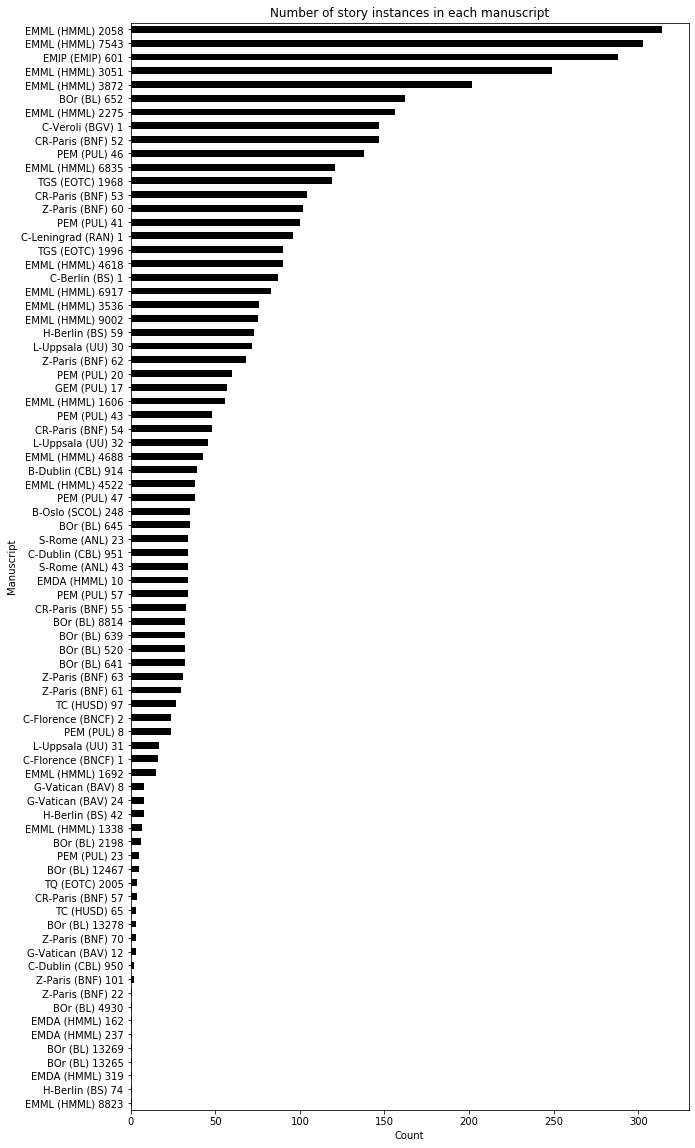

In [8]:
ax = (
    df_s.groupby('Manuscript')['Integer ID']
        .count()
        .sort_values()
        .plot(kind='barh', figsize=(10, 20), color='k')
)

ax.set_title('Number of story instances in each manuscript')
ax.set_ylabel('Manuscript')
ax.set_xlabel('Count')
None

## How often does each Story ID appear?

In [24]:
def get_story_name(df, story_id):
    return df[df['Canonical Story ID'] == story_id]['Canonical Story Title'].unique().tolist()[0]

popular_stories = df_s['Canonical Story ID'].value_counts()[:10]

print('Top 10 Most Frequent Stories\n')
for i, (story_id, count) in enumerate(popular_stories.iteritems()):
    story_name = get_story_name(df_s, story_id)
    print(f'\t#{i+1}\n\tStory ID: {story_id}\n\tCount: {count}\n\t{story_name}\n')

Top 10 Most Frequent Stories

	#1
	Story ID: 142
	Count: 58
	The deacon's prayer that contained five times "Rejoice!" [tafassehiyat].

	#2
	Story ID: 140
	Count: 51
	The sinful deacon whom his enemies could not kill until he had confessed himself to a priest.

	#3
	Story ID: 163
	Count: 51
	The Muslim whom Saint Mary told to receive baptism. Later, as Bishop of Rome, he cut off his hand because of a carnal thought.

	#4
	Story ID: 13
	Count: 50
	The composition of the Miracles of Mary by Bishop Hildephonsus of Toledo.

	#5
	Story ID: 154
	Count: 48
	The two women who were attacked by robbers on their way to church.

	#6
	Story ID: 153
	Count: 47
	The young man who used to bring roses to the icon of Saint Mary.

	#7
	Story ID: 187
	Count: 47
	The peasant who complained to Saint Mary because she did not reply to his Hail Mary.

	#8
	Story ID: 125
	Count: 47
	The story of the cannibal from Qemer.

	#9
	Story ID: 162
	Count: 45
	The pious monk scribe who used to write Saint Mary's name in 

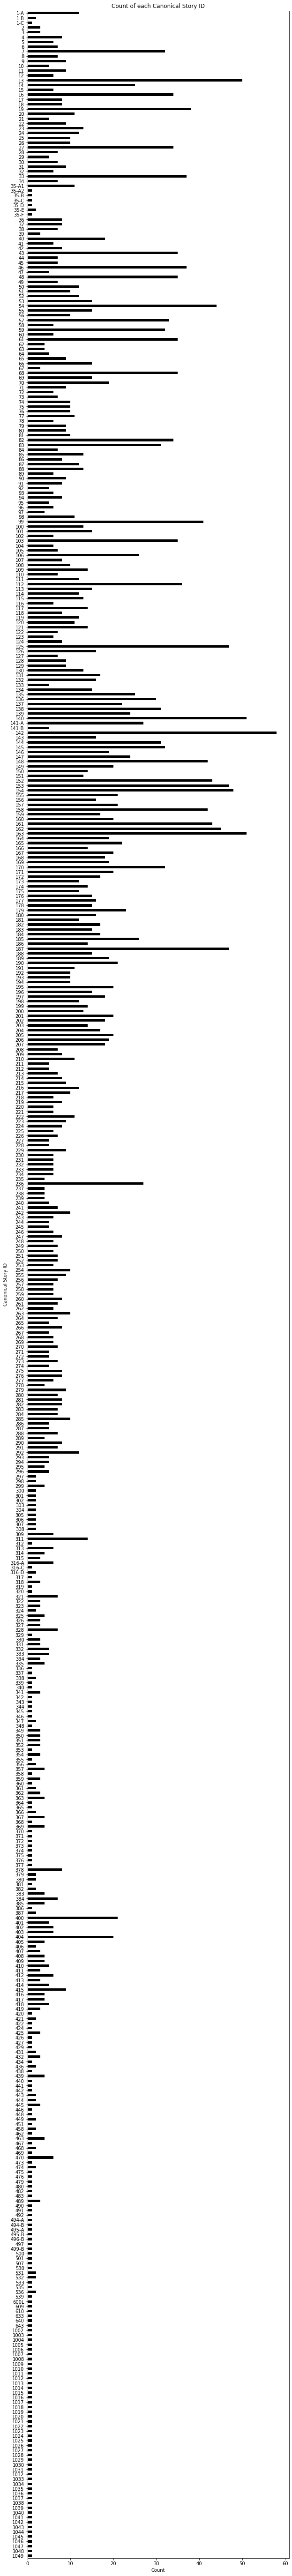

In [10]:
m = df_s['Canonical Story ID'].value_counts()

# NOTE: Pandas does not support custom sort functions, so a separate dataframe was necessary
df_t = pd.DataFrame(m)
df_t['t'] = df_t.index
df_t['Integer ID'] = df_t['t'].apply(lambda x: int_id_mapper[x])
df_t = df_t[['Canonical Story ID', 'Integer ID']]

ax = (
    df_t
        .sort_values(by='Integer ID')['Canonical Story ID']
        .plot(kind='barh', color='k', figsize=(10, 100))
)

ax.set_title('Count of each Canonical Story ID')
ax.set_xlabel('Count')
ax.set_ylabel('Canonical Story ID')
ax.invert_yaxis()

## What is the distribution of the Levenshtein edit distance?
Compare each manuscript to it's ordered contiguous counterpart. How many changes need to be made to get from the manuscript's order and the "ideal" order. 

[Learn more about the  Levenshtein edit distance](https://en.wikipedia.org/wiki/Levenshtein_distance)

In [25]:
def contiguous(l):
    return list(range(min(l), max(l)+1))

def levenshteinDistance(s1, s2):
    # this was copy-and-pasted from stack overflow, better review is needed
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

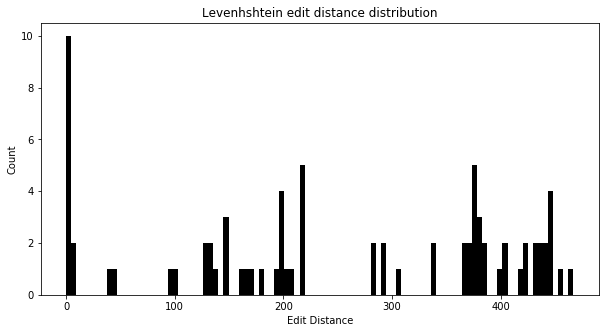

In [26]:
ld = [levenshteinDistance(man, contiguous(man)) for man in all_manuscripts]

plt.figure(figsize=(10, 5))
plt.hist(ld, bins=100, color='k')
plt.title('Levenhshtein edit distance distribution')
plt.xlabel('Edit Distance')
plt.ylabel('Count')
None

## Story ID's neighbors
A colocation json is created to analyze a story ID's most frequent neighbors

In [27]:
neighbor_d = {x: {'before': [], 'after': []} for x in unique_ids}
for man in all_manuscripts:
    for i, story_id in enumerate(man):
        if i == 0:
            neighbor_d[story_id]['before'].append('F')
            if len(man) != 1:
                neighbor_d[story_id]['after'].append(man[i+1])
            else:
                neighbor_d[story_id]['after'].append('L')
        elif i == len(man)-1:
            neighbor_d[story_id]['before'].append(man[i-1])
            neighbor_d[story_id]['after'].append('L')
        else:
            neighbor_d[story_id]['before'].append(man[i-1])
            neighbor_d[story_id]['after'].append(man[i+1])

with open('collocation.json', 'w') as f:
    json.dump(neighbor_d, f)

### What IDs are most commonly first and last in a manuscript?

In [28]:
first_count = []
for x, d in neighbor_d.items():
    first_count.append([x, d['before'].count('F')])
df_fc = pd.DataFrame(first_count, columns=['ID', 'Count'])
df_fc['Canonical Story ID'] = df_fc['ID'].apply(lambda x: reverse_id_mapper[x])
df_fc = df_fc.sort_values('Count', ascending=False) 

df_fc = df_fc[df_fc['Count'] > 1]
df_fc['Canonical Story Title'] = df_fc['Canonical Story ID'].apply(lambda x: get_story_name(df_s, x))

print('Stories that appear first more than once:')
for i,(_, r) in enumerate(df_fc.iterrows()):
    print(f"\t#{i+1} — count {r['Count']}\n\t{r['Canonical Story Title']}\n")

Stories that appear first more than once:
	#1 — count 37
	The composition of the Miracles of Mary by Bishop Hildephonsus of Toledo.

	#2 — count 4
	The composition of the Wǝddāse Maryam by the Syrian potter.

	#3 — count 4
	The monk who saved the church of Saint Mary in Atrib by his prayers when its destruction had been ordered by the Caliph.

	#4 — count 3
	The rich man who threw dry bread to a beggar in the name of Saint Mary.

	#5 — count 3
	The five sorrows of Saint Mary.

	#6 — count 2
	Ark of Zion cycle: The beginning of the history of the Ark of Zion in the giving of the Ten Commandments.

	#7 — count 2
	The peasant who complained to Saint Mary because she did not reply to his Hail Mary.



In [29]:
last_count = []
for x, d in neighbor_d.items():
    last_count.append([x, d['after'].count('L')])
df_lc = pd.DataFrame(last_count, columns=['ID', 'Count'])
df_lc['Canonical Story ID'] = df_lc['ID'].apply(lambda x: reverse_id_mapper[x])
df_lc = df_lc.sort_values('Count', ascending=False) 

df_lc = df_lc[df_lc['Count'] > 1]
df_lc['Canonical Story Title'] = df_lc['Canonical Story ID'].apply(lambda x: get_story_name(df_s, x))

print('Stories that appear first more than once:\n')
for i,(_, r) in enumerate(df_lc.iterrows()):
    print(f"\t#{i+1}\n\tCanonical Story ID: {r['Canonical Story ID']}\n\tCount: {r['Count']}\n\t{r['Canonical Story Title']}\n")

Stories that appear first more than once:

	#1
	Canonical Story ID: 236
	Count: 5
	Saint Mary gives a thirsty dog water to drink from her shoe.

	#2
	Canonical Story ID: 400
	Count: 5
	The five sorrows of Saint Mary.

	#3
	Canonical Story ID: 125
	Count: 3
	The story of the cannibal from Qemer.

	#4
	Canonical Story ID: 292
	Count: 3
	Däbrä Metmaq miracles: Saint Mary shows those assembled at Däbrä Metmaq a negative vision of Mohammad

	#5
	Canonical Story ID: 54
	Count: 2
	Saint Mary carries a dying monk to Jerusalem.

	#6
	Canonical Story ID: 148
	Count: 2
	The pregnant woman who was caught by the tide while going to the church of Saint Michael (Mont Saint Michel)

	#7
	Canonical Story ID: 309
	Count: 2
	Saint Mary appears to an official who kidnapped a girl that had made a vow of virginity.

	#8
	Canonical Story ID: 311
	Count: 2
	A stream runs uphill after his neighbor had diverted it.

	#9
	Canonical Story ID: 14
	Count: 2
	The composition of the Wǝddāse Maryam by the Syrian potte

### Collocation matrices
Displays how often IDs precede or follow another story. 

In [15]:
def perc(map_dict, i, c):
    l = map_dict.get(i, [])
    return np.nan if len(l) == 0 else round(l.count(c)/len(l)*100, 2)

before_map = {x: d['before'] for x, d in neighbor_d.items()}
after_map = {x: d['after'] for x, d in neighbor_d.items()}

df_b = pd.DataFrame(columns=['F'] + list(range(N)), index=range(N))
for c in df_b.columns:
    df_b[c] = [perc(before_map, i, c) for i in df_b.index]

df_a = pd.DataFrame(columns=list(range(N)) + ['L'], index=range(N))
for c in df_a.columns:
    df_a[c] = [perc(after_map, i, c) for i in df_a.index]

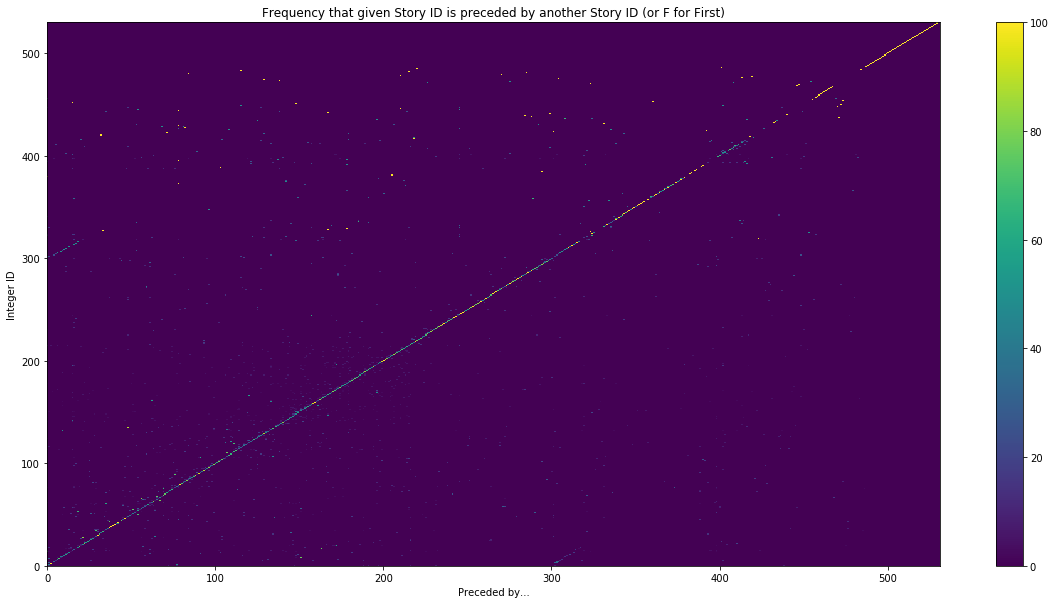

In [16]:
plt.figure(figsize=(20, 10)) 
plt.pcolor(df_b, vmin=0, vmax=100)
plt.ylabel('Integer ID')
plt.xlabel('Preceded by...')
plt.colorbar()
plt.title('Frequency that given Story ID is preceded by another Story ID (or F for First)')
None

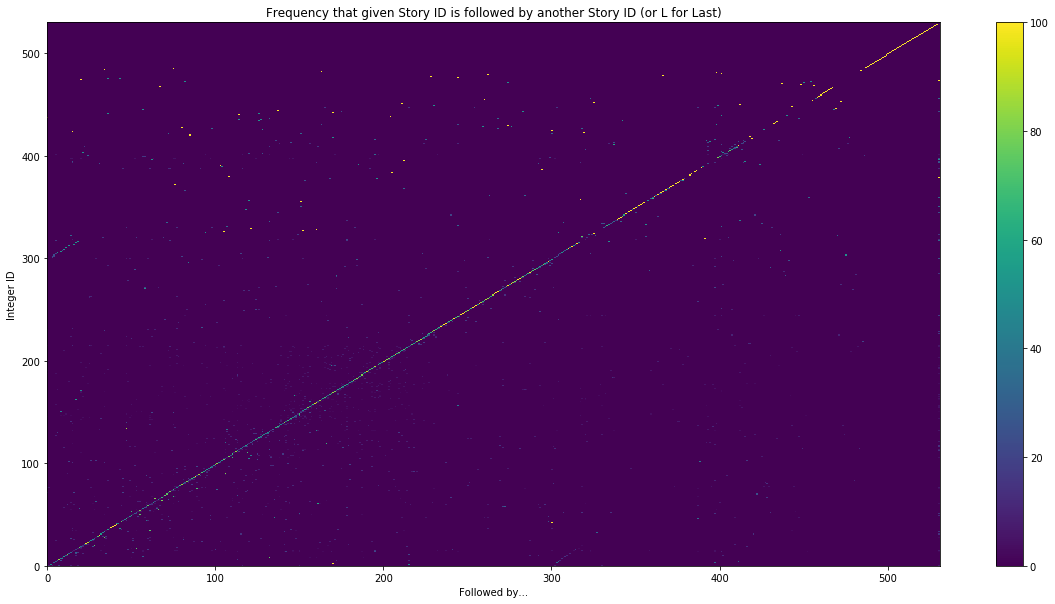

In [17]:
plt.figure(figsize=(20, 10)) 
plt.pcolor(df_a, vmin=0, vmax=100)
plt.xlabel('Followed by...')
plt.ylabel('Integer ID')
plt.colorbar()
plt.title('Frequency that given Story ID is followed by another Story ID (or L for Last)')
None

## Can we categorize the different permutations?

Currently we have:
* Sorted: meaning that the IDs are in order
* Reordered: meaning that the IDs, if sorted, would be contiguous
* Contiguous: they follow the order of Canonical IDs

Ideally we'd want the "Other" category to be as low as possible, so other unique categorizations are welcome.

In [18]:
def is_sorted(l):
    # e.g. 1-2-3-10-15
    return (sorted(l) == l)

def is_reordered(l):
    # e.g. 1-2-3-5-4
    return (sorted(l) == contiguous(l)) and not l == contiguous(l)

def is_contiguous(l):
    # e.g. 1-2-3-4-5
    return contiguous(l) == l

def get_perc(j, func):
    return round(len([1 for man in j if func(man)])/len(j)*100, 2)

{'Sorted': 16.46, 'Contiguous': 12.66, 'Reordered': 0.0, 'Other': 70.88}

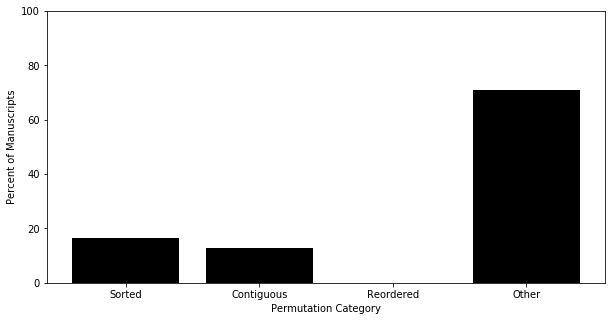

In [19]:
alteration_type = {
    'Sorted': get_perc(all_manuscripts, is_sorted),
    'Contiguous': get_perc(all_manuscripts, is_contiguous),
    'Reordered': get_perc(all_manuscripts, is_reordered)
}

alteration_type['Other'] = 100 - sum(alteration_type.values())

plt.figure(figsize=(10, 5))
plt.bar(alteration_type.keys(), alteration_type.values(), color='k')
plt.ylim((0, 100))
plt.xlabel('Permutation Category')
plt.ylabel('Percent of Manuscripts')
alteration_type